# Plus proches voisins - projection

On projette le jeu de données initiale selon les premiers axes d'une [analyse en composantes principales (ACP)](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales).

In [1]:
%matplotlib inline

In [2]:
from papierstat.datasets import load_wines_dataset
df = load_wines_dataset()
X = df.drop(['quality', 'color'], axis=1)
y = df['quality']

On utilise la classe [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
pca = PCA(n_components=5)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

On regarde la variance expliquée par chaque axe : la valeur propre.

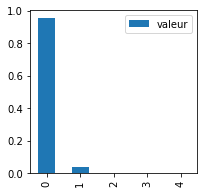

In [4]:
import pandas
eig = pandas.DataFrame(dict(valeur=pca.explained_variance_ratio_))
eig.plot(kind='bar', figsize=(3,3));

Le premier explique une grande part de la variance, trop grande. C'est louche. Regardons les coordonnées du premier axe.

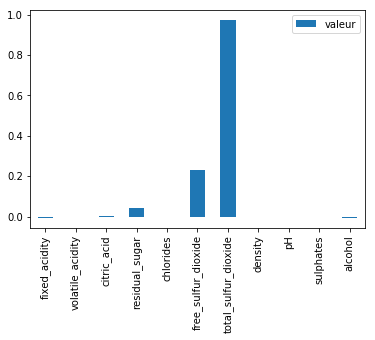

In [5]:
v1 = pandas.DataFrame(dict(valeur=pca.components_[0,:]))
v1.index = df.columns[:-2]
v1.plot(kind='bar')

Il est quasiment égal à une seule coordonnées. Cela suppose que les variables ont des échelles différentes.

In [6]:
df.iloc[:, 3:8].describe()

,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,5.443235,0.056034,30.525319,115.744574,0.994697
std,4.757804,0.035034,17.749400,56.521855,0.002999
min,0.600000,0.009000,1.000000,6.000000,0.987110
25%,1.800000,0.038000,17.000000,77.000000,0.992340
50%,3.000000,0.047000,29.000000,118.000000,0.994890
75%,8.100000,0.065000,41.000000,156.000000,0.996990
max,65.800000,0.611000,289.000000,440.000000,1.038980


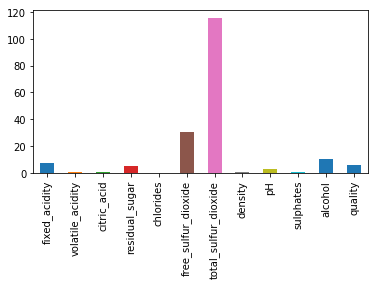

In [7]:
mean_val = df.describe().T['mean']
mean_val.index = df.columns[:-1]
mean_val.plot(kind='bar', figsize=(6,3))

La valeur moyenne de chaque variable ressemble étrangement aux coordonnées du premier axe de l'ACP. Il faut normaliser les données avec [normalize](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

In [8]:
pca = PCA(n_components=5)
Xn = normalize(X)
pca.fit(Xn)

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

C'est beaucoup mieux.

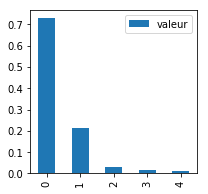

In [9]:
import pandas
eig = pandas.DataFrame(dict(valeur=pca.explained_variance_ratio_))
eig.plot(kind='bar', figsize=(3,3));

c:\Python364_x64\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


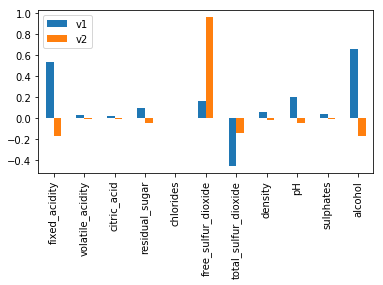

In [10]:
v2 = pandas.DataFrame(pca.components_[0:2,:]).T
v2.index = df.columns[:-2]
v2.columns = ['v1', 'v2']
ax = v2.plot(y=['v1', 'v2'], kind='bar', figsize=(6,3))
ax.legend(loc='upper left');

L'alcool, l'acidité, le dioxyde, le pH semble jouer un rôle plus grand que les autres variables. On projette maintenant les observations.

In [11]:
proj = pca.transform(Xn)

In [12]:
pl = pandas.DataFrame(proj[:, :3])
pl.columns = ['v1', 'v2', 'v3']
pl['quality'] = df['quality']
pl['color'] = df['color']

Premier graphe selon les couleurs.

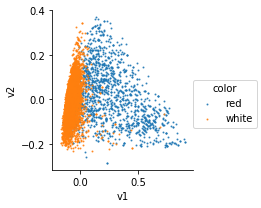

In [13]:
import seaborn
seaborn.lmplot(x="v1", y="v2", hue="color", truncate=True, data=pl, scatter_kws={"s": 1},
               fit_reg=False, size=3);

Autre façon de tracer le même graphe.

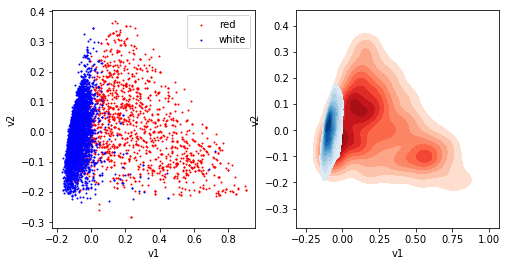

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

red = pl[pl.color == 'red']
white = pl[pl.color == 'white']

# second graphd avec pandas                                                                     
red.plot(x='v1', y='v2', label='red', kind='scatter', ax=ax[0], color="red", s=1)
white.plot(x='v1', y='v2', label='white', kind='scatter', ax=ax[0], color="blue", s=1)

# troisième graphe pour la densité
seaborn.kdeplot(red.v1, red.v2, cmap="Reds", shade=True, shade_lowest=False, ax=ax[1])
seaborn.kdeplot(white.v1, white.v2, cmap="Blues", shade=True, shade_lowest=False, ax=ax[1]);

Avec le troisième axe.

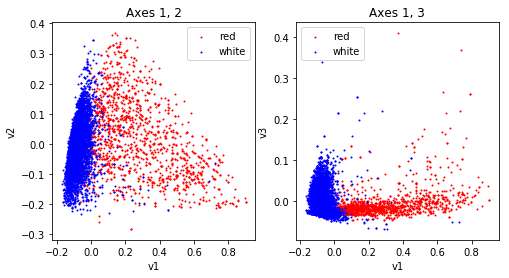

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

red = pl[pl.color == 'red']
white = pl[pl.color == 'white']

red.plot(x='v1', y='v2', label='red', kind='scatter', ax=ax[0], color="red", s=1)
white.plot(x='v1', y='v2', label='white', kind='scatter', ax=ax[0], color="blue", s=1)
ax[0].set_title("Axes 1, 2")
red.plot(x='v1', y='v3', label='red', kind='scatter', ax=ax[1], color="red", s=1)
white.plot(x='v1', y='v3', label='white', kind='scatter', ax=ax[1], color="blue", s=1)
ax[1].set_title("Axes 1, 3");

On représente maintenant les notes des vins.

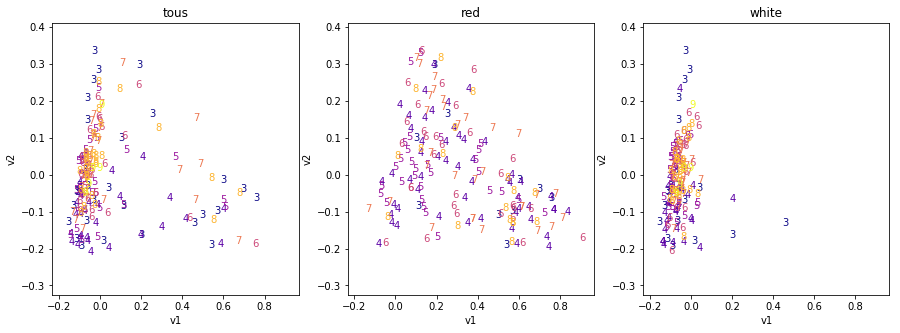

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Choisir un dégragé ici
cmap = plt.get_cmap('plasma') 
cnorm = colors.Normalize(vmin=pl['quality'].min(), vmax=pl['quality'].max())
scalar = cmx.ScalarMappable(norm=cnorm, cmap=cmap)

for i, data, title in [(0, pl, 'tous'), (1, red, 'red'), (2, white, 'white')]:
    ax = axs[i]
    # On trace les points pour que le texte n'apparaissent pas en dehors des zones
    pl.plot(x='v1', y='v2', kind='scatter', color="white", ax=ax)

    for note in sorted(set(data['quality'])):
        sub = data[data.quality == note]
        if sub.shape[0] > 100:
            sub = sub.sample(n=30)

        color = scalar.to_rgba(note)
        for i, row in enumerate(sub.itertuples()):
            ax.text(row[1], row[2], str(row[4]), color=color)
    ax.set_title(title);

Les vins rouges et blancs apparaissent comme très différents, cela vaudra sans doute le coup de faire deux modèles si la performance n'est pas assez bonne. Les bonnes notes ne se détache pas particulièremnt sur ces graphes. Le problème est peut-être simple mais ce ne sont pas ces graphes qui vont nous le dire.